# CSE 6240 Homework 2  
## Problem 3. ImageNet

__Name: Qi Zheng__  
__GTID: qzheng61__

### Notes:
__Results are summarized at the beginning of each section.__

In [795]:
import os
import glob
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.misc import imresize
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from skimage import color
from collections import Counter
from IPython.display import display
from pandas import DataFrame as DF

In [16]:
np.random.seed(seed=0)

## 1. Image Pre-processing

In [3]:
try:
    images = np.load('ImageNet_img.npy')
    labels = np.load('ImageNet_Labl.npy')

except:
    foldername = ["n00017222_Plant", "n09287968_Geo", "n12992868_Fungus",
                  "n00523513_Sport", "n00007846_Person", "n00015388_Animal"]
    labels = []
    images = []
    lb = -1

    for folder in foldername:
        lb += 1
        flist = glob.glob(folder +'/*.JPEG')
        for fpath in flist:
            x = imread(fpath)
            if len(x.shape) == 3:
                x = imresize(x, (64,64,3))
                images.append(x)
                labels.append(lb)


In [4]:
images = np.array(images)
labels = np.array(labels)    

In [5]:
images.shape

(8973, 64, 64, 3)

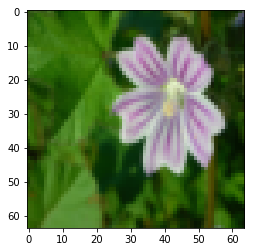

In [846]:
# Open a random image to check if images have been loaded and resized successfully.

plt.imshow(images[1])
plt.show()

In [8]:
np.save('ImageNet_img', images)
np.save('ImageNet_Labl', labels)

In [17]:
X_img = np.copy(images)
Y_lab = np.copy(labels)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X_img, Y_lab, test_size=0.2, random_state=0)

In [488]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## 2. Convert the Images to Vectors (4 ways)

## Autoencoder

In [133]:
input_img = Input(shape=(64, 64, 3))


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [134]:
ae_train = np.copy(x_train)
ae_test = np.copy(x_test)

ae_train = ae_train.astype('float32') / 255.
ae_test = ae_test.astype('float32') / 255.

# ae_train = ae_train.reshape((len(ae_train), np.prod(ae_train.shape[1:])))
# ae_test = ae_test.reshape((len(ae_test), np.prod(ae_test.shape[1:])))

In [135]:
autoencoder.fit(ae_train, ae_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(ae_test, ae_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')],
                verbose=2)

Train on 7178 samples, validate on 1795 samples
Epoch 1/10
95s - loss: 0.6554 - mean_squared_error: 0.0523 - val_loss: 0.5994 - val_mean_squared_error: 0.0269
Epoch 2/10
95s - loss: 0.5951 - mean_squared_error: 0.0254 - val_loss: 0.5881 - val_mean_squared_error: 0.0223
Epoch 3/10
100s - loss: 0.5813 - mean_squared_error: 0.0195 - val_loss: 0.5730 - val_mean_squared_error: 0.0162
Epoch 4/10
103s - loss: 0.5737 - mean_squared_error: 0.0164 - val_loss: 0.5676 - val_mean_squared_error: 0.0137
Epoch 5/10
102s - loss: 0.5695 - mean_squared_error: 0.0147 - val_loss: 0.5647 - val_mean_squared_error: 0.0128
Epoch 6/10
96s - loss: 0.5661 - mean_squared_error: 0.0133 - val_loss: 0.5670 - val_mean_squared_error: 0.0137
Epoch 7/10
96s - loss: 0.5640 - mean_squared_error: 0.0125 - val_loss: 0.5593 - val_mean_squared_error: 0.0107
Epoch 8/10
96s - loss: 0.5617 - mean_squared_error: 0.0116 - val_loss: 0.5628 - val_mean_squared_error: 0.0119
Epoch 9/10
96s - loss: 0.5599 - mean_squared_error: 0.0109 - 

__Save the trained autoencoder (model) for future use.__

In [136]:
# serialize model to JSON
autoencoder_json = autoencoder.to_json()
with open("autoencoder.json", "w") as json_file:
    json_file.write(autoencoder_json)
# serialize weights to HDF5
autoencoder.save_weights("autoencoder.h5")
print("Saved autoencoder model to disk")

# serialize model to JSON
encoder_json = encoder.to_json()
with open("encoder.json", "w") as json_file:
    json_file.write(encoder_json)
# serialize weights to HDF5
encoder.save_weights("encoder.h5")
print("Saved encoder model to disk")

# # REUSE
# # load json and create model
# json_file = open('autoencoder.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("autoencoder.h5")
# print("Loaded model from disk")

# # load json and create model
# json_file = open('encoder.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("encoder.h5")
# print("Loaded model from disk")

# # Use loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# encoder = loaded_model
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Saved autoencoder model to disk
Saved encoder model to disk


In [137]:
ae_train_encoded = encoder.predict(ae_train)
ae_test_encoded = encoder.predict(ae_test)

In [151]:
print(ae_train_encoded.shape)
print(ae_test_encoded.shape)

(7178, 16, 16, 32)
(1795, 16, 16, 32)


In [154]:
aetr_vec = []
for tr in ae_train_encoded:
    aetr_vec.append(tr.flatten())
aetr_vec = np.array(aetr_vec)

aets_vec = []
for ts in ae_test_encoded:
    aets_vec.append(ts.flatten())
aets_vec = np.array(aets_vec)

In [157]:
np.save('ae_train', ae_train)
np.save('ae_test', ae_test)
np.save('ae_train_encoded', ae_train_encoded)
np.save('ae_test_encoded', ae_test_encoded)

In [158]:
print(aetr_vec.shape)
print(aets_vec.shape)

(7178, 8192)
(1795, 8192)


## SVD

In [384]:
svd_train = np.copy(x_train)
svd_test = np.copy(x_test)

In [535]:
svd_train = np.array([tr.flatten() for tr in svd_train])
svd_test = np.array([ts.flatten() for ts in svd_test])

print(svd_train.shape)
print(svd_test.shape)

pca_encoder = PCA(n_components=600)
svd_tr_encoded = pca_encoder.fit_transform(svd_train)
svd_ts_encoded = pca_encoder.transform(svd_test)

(7178, 12288)
(1795, 12288)


In [536]:
print(svd_tr_encoded.shape)
print(svd_ts_encoded.shape)

(7178, 600)
(1795, 600)


## RGB Histograms 

In [215]:
def rgb_hist(img):
    RGB_ct = np.zeros(shape=(3, 256))
    for i in range(3):
        channel = img[:,:,i].flatten()
        for val in channel:
            RGB_ct[i][val]+=1
    return RGB_ct

--------------------------------------------------------------------------------------------------------------------  
#### The following codes are just used for accuracy checking: plot RGB histograms for a random image to check the accuracy. 



Sample: RGB Histograms for images[1]


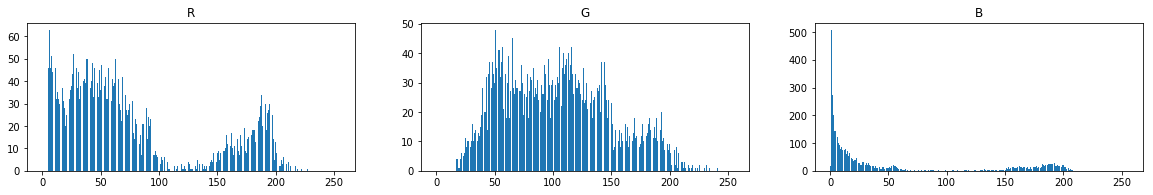

In [277]:
RGB = rgb_hist(images[1])
colors = ['R', 'G', 'B']
print('\n\nSample: RGB Histograms for images[1]')
plt.figure(figsize=(20, 6))

for i in range(3):
    ax = plt.subplot(2, 3, i + 1)
    plt.title(colors[i])
    plt.bar(np.array(range(256)), RGB[i])
plt.show()



Sample: RGB Histograms for images[1](for comparison)


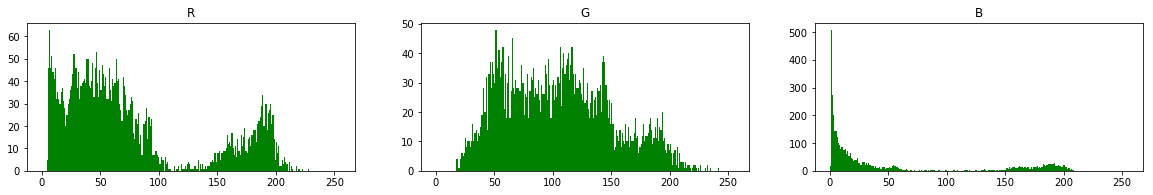

In [323]:
print('\n\nSample: RGB Histograms for images[1](for comparison)')
plt.figure(figsize=(20, 6))
for i in range(3):
    ax = plt.subplot(2, 3, i + 1)
    plt.title(colors[i])
    plt.hist(images[1][:,:,i].flatten(), bins=np.array(range(256)), color = 'g')
plt.show()

----------------------------------------------------------------------------------------------------------------------

In [392]:
RGB_tr_vec = np.array([rgb_count(tr) for tr in x_train])
RGB_ts_vec = np.array([rgb_count(ts) for ts in x_test])

In [393]:
print(RGB_tr_vec.shape)
print(RGB_ts_vec.shape)

(7178, 3, 256)
(1795, 3, 256)


In [394]:
# Create RGB vectors for training and test sets

RGB_tr_vec = np.array([tr.flatten() for tr in RGB_tr_vec])
RGB_ts_vec = np.array([ts.flatten() for ts in RGB_ts_vec])

In [395]:
print(RGB_tr_vec.shape)
print(RGB_ts_vec.shape)

(7178, 768)
(1795, 768)


## HSV Histograms 

In [404]:
# Each image will be bined to a flattened numpy array
# of length (180+256+256) based on HSV histograms

def hsv_histvec(img):
    hsv = []
    hsvbins=[180, 256, 256]
    for i in range(3):
        channel = img[:,:,i].flatten()
        (hsv_ct, _) = np.histogram(channel, bins=hsvbins[i])
        hsv.append(hsv_ct)
    [H, S, V] = hsv
    hsv_vec = np.concatenate((H, S, V))
    return hsv_vec

In [405]:
img1_vec = hsv_histvec(images[1])
print(img1_vec.shape)

(692,)


In [406]:
# Create HSV vectors for training and testing sets

HSV_tr_vec = np.array([hsv_histvec(tr) for tr in x_train])
HSV_ts_vec = np.array([hsv_histvec(ts) for ts in x_test])                    

In [408]:
print(HSV_tr_vec.shape)
print(HSV_ts_vec.shape)

(7178, 692)
(1795, 692)


## 3. Compare Classification Results

In [455]:
L = x_test.shape[0]
k = 5   # use KNN = 5

### Majoriety Voting Classification Using Euclidean Distance KNN

#### Prediction Accuracies using Euclidean Distance KNN:

Accuracy for Method AE is: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__0.38272980501392756__  
Accuracy for Method SVD is: &nbsp;&nbsp;&nbsp;__0.3392757660167131__  
Accuracy for Method RGB is: &nbsp;&nbsp;&nbsp;__0.3532033426183844__  
Accuracy for Method HSV is: &nbsp;&nbsp;&nbsp;&nbsp;__0.3153203342618384__  

In [540]:
# Euclidean Distance KNN function

def euc_knn(train, test, k, L):
    KNN = np.zeros(shape=(L, k))
    disM = euclidean_distances(test, train)
    ct = 0
    for line in disM:
        KNN[ct, :] = np.argsort(line)[:k]
        ct += 1
    return KNN

In [541]:
# Calculate KNN from datasets generated using 4 methods

knn_AE = euc_knn(aetr_vec, aets_vec, k, L)
knn_SVD = euc_knn(svd_tr_encoded, svd_ts_encoded, k, L)
knn_RGB = euc_knn(RGB_tr_vec, RGB_ts_vec, k, L)
knn_HSV = euc_knn(HSV_tr_vec, HSV_ts_vec, k, L)

In [542]:
# Function to get the label

def get_label(y_train, indM, k, L):
    indM = indM.astype(int)
    label = np.zeros(shape=(L, k))
    for i in range(L):
        label[i] = y_train[indM[i]]
    return label

In [543]:
knnlab_AE = get_label(y_train, knn_AE, k, L).astype(int)
knnlab_SVD = get_label(y_train, knn_SVD, k, L).astype(int)
knnlab_RGB = get_label(y_train, knn_RGB, k, L).astype(int)
knnlab_HSV = get_label(y_train, knn_HSV, k, L).astype(int)

In [544]:
pred_AE = np.array([Counter(votes).most_common(1)[0][0] for votes in knnlab_AE])
pred_SVD = np.array([Counter(votes).most_common(1)[0][0] for votes in knnlab_SVD])
pred_RGB = np.array([Counter(votes).most_common(1)[0][0] for votes in knnlab_RGB])
pred_HSV= np.array([Counter(votes).most_common(1)[0][0] for votes in knnlab_HSV])

In [545]:
diff_AE = pred_AE - y_test
acu_AE = np.count_nonzero(diff_AE==0)/L
diff_SVD = pred_SVD - y_test
acu_SVD = np.count_nonzero(diff_SVD==0)/L
diff_RGB = pred_RGB - y_test
acu_RGB = np.count_nonzero(diff_RGB==0)/L
diff_HSV = pred_HSV - y_test
acu_HSV = np.count_nonzero(diff_HSV==0)/L

In [755]:
Method = ['AE', 'SVD', 'RGB', 'HSV']
acu = [acu_AE, acu_SVD, acu_RGB, acu_HSV]
print('\nAccuracy Results (Euclidean Distance KNN:\n')
for i in range(4):
    print('Accuracy for Method', Method[i],'is:', acu[i])
print()


Accuracy Results (Euclidean Distance KNN:

Accuracy for Method AE is: 0.38272980501392756
Accuracy for Method SVD is: 0.3392757660167131
Accuracy for Method RGB is: 0.3532033426183844
Accuracy for Method HSV is: 0.3153203342618384



--------------------------------------------------------------------------------------------------------------------  
### Majoriety Voting Classification Using Pearson Correlation KNN

#### Prediction Accuracies (Pearson Correlation KNN):

Accuracy for Method AE is: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__0.4155988857938719__  
Accuracy for Method SVD is: &nbsp;&nbsp;&nbsp;&nbsp;__0.40445682451253484__  
Accuracy for Method RGB is: &nbsp;&nbsp;&nbsp;&nbsp;__0.3793871866295265__  
Accuracy for Method HSV is: &nbsp;&nbsp;&nbsp;&nbsp;__0.3637883008356546__  


In [757]:
def pearson_matrix(test, train):
    M = np.corrcoef(test, train)
    dim = test.shape[0]
    return M[:dim, dim:]

In [758]:
def pearson_knn(train, test, k, L):
    KNN = np.zeros(shape=(L, k))
    disM = pearson_matrix(test, train)
    ct = 0
    for line in disM:
        KNN[ct, :] = np.argsort(line)[-k:][::-1]
        ct += 1
    return KNN

In [759]:
pknn_AE = pearson_knn(aetr_vec, aets_vec, k, L)
pknn_SVD = pearson_knn(svd_tr_encoded, svd_ts_encoded, k, L)
pknn_RGB = pearson_knn(RGB_tr_vec, RGB_ts_vec, k, L)
pknn_HSV = pearson_knn(HSV_tr_vec, HSV_ts_vec, k, L)

In [760]:
pknnlab_AE = get_label(y_train, pknn_AE, k, L).astype(int)
pknnlab_SVD = get_label(y_train, pknn_SVD, k, L).astype(int)
pknnlab_RGB = get_label(y_train, pknn_RGB, k, L).astype(int)
pknnlab_HSV = get_label(y_train, pknn_HSV, k, L).astype(int)

In [761]:
ppred_AE = np.array([Counter(votes).most_common(1)[0][0] for votes in pknnlab_AE])
ppred_SVD = np.array([Counter(votes).most_common(1)[0][0] for votes in pknnlab_SVD])
ppred_RGB = np.array([Counter(votes).most_common(1)[0][0] for votes in pknnlab_RGB])
ppred_HSV= np.array([Counter(votes).most_common(1)[0][0] for votes in pknnlab_HSV])

In [762]:
pdiff_AE = ppred_AE - y_test
pacu_AE = np.count_nonzero(pdiff_AE==0)/L
pdiff_SVD = ppred_SVD - y_test
pacu_SVD = np.count_nonzero(pdiff_SVD==0)/L
pdiff_RGB = ppred_RGB - y_test
pacu_RGB = np.count_nonzero(pdiff_RGB==0)/L
pdiff_HSV = ppred_HSV - y_test
pacu_HSV = np.count_nonzero(pdiff_HSV==0)/L

In [763]:
pacu = [pacu_AE, pacu_SVD, pacu_RGB, pacu_HSV]
print('\nAccuracy Results (Pearson Coefficient KNN:\n')
for i in range(4):
    print('Accuracy for Method', Method[i],'is:', pacu[i])
print()


Accuracy Results (Pearson Coefficient KNN:

Accuracy for Method AE is: 0.4155988857938719
Accuracy for Method SVD is: 0.40445682451253484
Accuracy for Method RGB is: 0.3793871866295265
Accuracy for Method HSV is: 0.3637883008356546



## Construct Eight 6x6 Confusion Matrics  
### 8 matrices = 4 vectorization methods * 2 KNN measuring approaches

In [778]:
def conf_mat(y_test, y_pred, L):
    Mx = np.zeros(shape=(6, 6), dtype=int)
    for i in range(L):
        row = y_test[i]
        col = y_pred[i]
        Mx[row, col] += 1
    return Mx

In [812]:
def print_accu(Mx, name):
    acu_count = 0
    for i in range(6):
        acu_count += Mx[i, i]
    total_count = Mx.sum()
    accu = acu_count/total_count
    print(name, 'accuracy:', accu)
    print()

In [813]:
def Mx_print(Mx, name):
    Catg = ["Plant", "Geology", "Fungus", "Sport", "Person", "Animal"]
    df = DF(
        {"Plant": Mx[0],
         "Geology": Mx[1],
         "Fungus": Mx[2],
         "Sport": Mx[3],
         "Person": Mx[4],
         "Animal": Mx[5]},
         index=Catg, columns=Catg)
    display(df)
    print_accu(Mx, name)

In [815]:
# Construct 8 confusion matrics

Name = ['Autoencoder', 'SVD', 'RGB', 'HSV']

Mx_E = []
Mx_E.append(conf_mat(y_test, pred_AE, L))
Mx_E.append(conf_mat(y_test, pred_SVD, L))
Mx_E.append(conf_mat(y_test, pred_RGB, L))
Mx_E.append(conf_mat(y_test, pred_HSV, L))

Mx_P = []
Mx_P.append(conf_mat(y_test, ppred_AE, L))
Mx_P.append(conf_mat(y_test, ppred_SVD, L))
Mx_P.append(conf_mat(y_test, ppred_RGB, L))
Mx_P.append(conf_mat(y_test, ppred_HSV, L))

------------------------------------------------------------------------------------------------

## Table Display

### Confusion Matrices (Euclidean Distance)  
__ 4 Encoding/vectorization mehtod names and their corresponding accuracies are displayed beneath each table.__

In [816]:
for i in range(4):
    Mx_print(Mx_E[i], Name[i])

,Plant,Geology,Fungus,Sport,Person,Animal
Plant,113,24,37,38,18,47
Geology,51,281,67,154,104,128
Fungus,35,5,76,16,20,22
Sport,9,15,13,73,14,15
Person,7,5,2,10,46,16
Animal,41,25,43,67,60,98


Autoencoder accuracy: 0.382729805014



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,98,20,26,30,16,45
Geology,67,281,82,172,117,138
Fungus,23,5,56,8,18,21
Sport,8,10,7,47,13,18
Person,8,12,2,8,37,14
Animal,52,27,65,93,61,90


SVD accuracy: 0.339275766017



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,104,27,44,39,8,54
Geology,21,154,18,50,38,48
Fungus,72,62,133,101,71,90
Sport,21,27,8,98,35,30
Person,12,25,13,21,77,36
Animal,26,60,22,49,33,68


RGB accuracy: 0.353203342618



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,63,33,32,23,15,43
Geology,32,127,13,33,27,32
Fungus,91,89,116,94,67,113
Sport,21,40,29,127,44,44
Person,17,25,20,26,74,35
Animal,32,41,28,55,35,59


HSV accuracy: 0.315320334262



### Confusion Matrices (Pearson Correlation)  
__4 Encoding/vectorization mehtod names and their corresponding accuracies are displayed beneath each table.__

In [817]:
for i in range(4):
    Mx_print(Mx_P[i], Name[i])

,Plant,Geology,Fungus,Sport,Person,Animal
Plant,117,20,38,31,13,37
Geology,45,277,59,137,90,109
Fungus,38,12,84,28,23,32
Sport,11,15,7,88,10,23
Person,14,13,9,18,82,27
Animal,31,18,41,56,44,98


Autoencoder accuracy: 0.415598885794



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,97,14,29,17,8,14
Geology,53,245,44,104,78,81
Fungus,30,16,81,13,16,32
Sport,14,20,8,99,12,28
Person,34,38,48,66,99,66
Animal,28,22,28,59,49,105


SVD accuracy: 0.404456824513



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,125,31,53,46,18,58
Geology,32,186,36,76,47,71
Fungus,60,43,108,68,59,70
Sport,4,25,4,97,21,21
Person,13,21,14,16,91,32
Animal,22,49,23,55,26,74


RGB accuracy: 0.37938718663



,Plant,Geology,Fungus,Sport,Person,Animal
Plant,97,39,54,38,20,56
Geology,31,165,28,42,40,66
Fungus,61,51,86,56,47,64
Sport,15,34,16,145,36,37
Person,25,21,18,38,89,32
Animal,27,45,36,39,30,71


HSV accuracy: 0.363788300836



## Summary  


### Overall:  
__A. the accuracies using majoriety voting from KNNs obtained using Pearson Correlation are higher than those otained from Euclidean Distance.__    
__B. the accuracies measured directly from pairing predicted and real labels of test sets match those calculated from confusing matrices.__